In [1]:
# %%
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from spore_tree_config import SporeTreeConfig
from spore_tree import SporeTree
from pendulum import PendulumSystem
from visualize_spore_tree import visualize_spore_tree
from tree_evaluator import TreeEvaluator

In [20]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

# Создание с дефолтными параметрами
config = SporeTreeConfig()
print("Дефолтная позиция:", config.initial_position)
print("Дефолтный вектор dt:", config.get_default_dt_vector())

init_position = np.array([np.pi/2, 0])
# Создание с кастомными параметрами  
config_custom = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.0001,
    figure_size=(10, 10),
    dt_grandchildren_factor=0.1  # 1/10
)
config_custom.validate()

Дефолтная позиция: [3.14159265 0.        ]
Дефолтный вектор dt: [1.e-03 1.e-03 1.e-03 1.e-03 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05 5.e-05
 5.e-05 5.e-05]


True

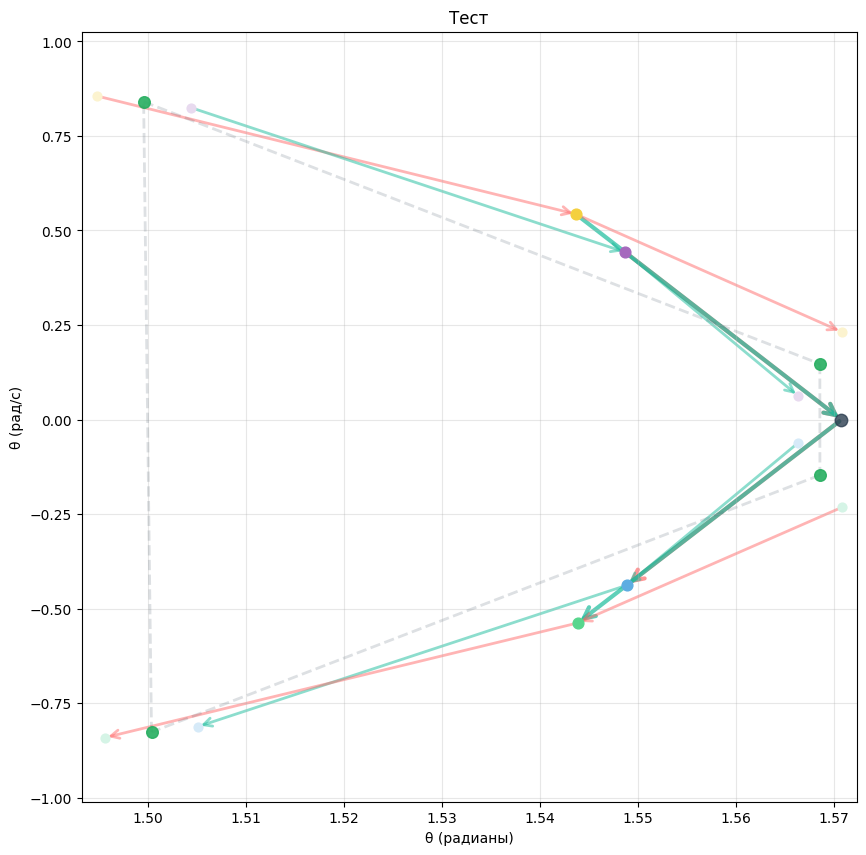

In [21]:
cfg = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=0.1,
    dt_grandchildren_factor=0.7,
    figure_size=(10, 10)
)

tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")

C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
C:\Users\vladi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Iteration limit reached    (Exit mode 9)
            Current function value: -0.0007429874799726073
            Iterations: 1000
            Function evaluations: 22251
            Gradient evaluations: 1000
pair distances: [0.000319 0.000558 0.000165 0.000524]
area: 0.0007429874799726073


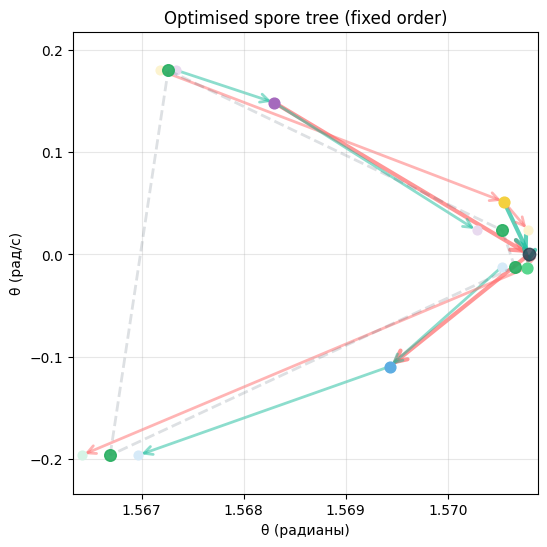

[0.02491719 0.03364405 0.00238356 0.00952374]
[0.01609015 0.01803883 0.02309552 0.00584701 0.04173315 0.00019104
 0.00633626 0.02911935]


In [22]:
dt = 0.1
cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=dt,
    figure_size=(6, 6),
    dt_grandchildren_factor=0.1,
)

tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()


bounds = [(0.00001, 0.05)]*12  # дети / внуки

dt_children = np.ones(4) * dt
dt_grandchildren = np.ones(8) * dt * 0.05
        
init_guess = np.hstack((dt_children, dt_grandchildren))


evaluator = TreeEvaluator(tree)

def objective(dt_all):
    return -evaluator.area(dt_all)          # maximize area → minimise (-area)

epsilon = 1e-5
constraints = [
    {
        'type': 'ineq',
        'fun': (lambda idx: lambda v: epsilon - evaluator.pair_distances(v)[idx])(i)
    }
    for i in range(4)
]

result = minimize(objective, init_guess, method='SLSQP',
                  bounds=bounds, constraints=constraints,
                  options={'maxiter': 1000, 'disp': True, 'eps': 1e-5})

print("pair distances:", np.round(evaluator.pair_distances(result.x), 6))
print("area:", -result.fun)
visualize_spore_tree(tree, title="Optimised spore tree (fixed order)")
print(result.x[:4])
print(result.x[4:])
